## Used Libraries

 - pandas 
 
 Load Dataset and Make Correction for text

 - pytorch 
 
 For making Datasets and Train The Classificator Model 
 
 - transformers
 
 For Load the XLM-RoBERTa model and tokenizer from hugging face 
 
 

# Describtion

## Roberta model
RoBERTa is like a super smart text reader that can tell what type of writing it's looking at. It's like having a million books worth of knowledge that helps it figure out if something is happy, sad, news, spam, or whatever.

It's really good at this task because:

It's been trained on tons of text, so it knows lots of words and how they're used.
It can handle many languages, not just English!
You can train it even more for specific jobs, like learning about jokes or poems.
This makes it useful for things like:

Understanding reviews so companies can know what people think.
Stopping bad emails from reaching your inbox.
Sorting news articles so you see what you care about most.
So, if you need a computer to understand different kinds of writing, RoBERTa is a powerful tool to have on your side!


## What this notebook doing 
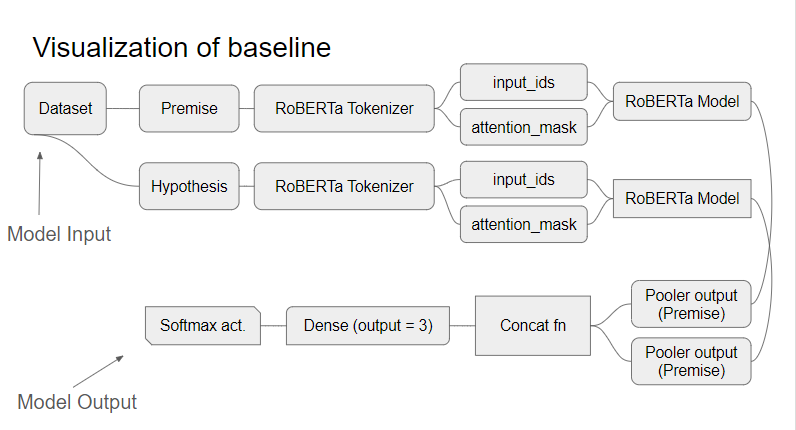

# Import Libraries (for load dataset and make visualizations) 

In [ ]:
import unicodedata
import re 

import matplotlib.pyplot as plt 
import pandas as pd

train_df = pd.read_csv('/kaggle/input/contradictory-my-dear-watson/train.csv')

# Learning Dataset

In [ ]:
# Countting all languages  
lan_counts = train_df['language'].value_counts()

# Making visualization
plt.barh(lan_counts.index, lan_counts.values)
plt.xlabel('Count')
plt.ylabel('Language')
plt.title('Count of each Language in Dataset')
plt.show()

In [ ]:
# making hist of "premise" lengths
lengths = train_df["premise"].apply(lambda i: len(i))
print('min:', min(lengths), ' -- max:', max(lengths))
lengths.hist(bins=30)
plt.title("'Premise' columns text lenghts")
plt.ylabel("count")
plt.xlabel("length")
plt.show()

In [ ]:
# making hist of "hypothesis" lengths
lengths = train_df["hypothesis"].apply(lambda i: len(i))
print('min:', min(lengths), ' -- max:', max(lengths))
lengths.hist(bins=30)
plt.title("'Hypothesis' columns text lenghts")
plt.ylabel("count")
plt.xlabel("length")
plt.show()

# Prepare Train Data (Text Correction)

In [ ]:
def remove_url(text):
    # Removes URL addresses from a string, if present
    return re.sub(r'https?://\S+|www\.\S+', '', text)

def remove_punctuation(text):
    # Removes all punctuation from a string, if present
    return re.sub(r'[^a-zA-Z0-9]', ' ', text)

def remove_extra_whitespaces(text):
    # Removes extra whitespaces from a string, if present
    return re.sub(r'^\s*|\s\s*', ' ', text).strip()

def remove_accented_chars(text):
    # Removes all accented characters from a string, if present
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

def preprocess_text_column(column, preprocess_steps=None):
    '''
    Preprocesses a text column in a DataFrame by applying a series of cleaning steps.

    Args:
        column (pandas.Series): The text column to be preprocessed.
        preprocess_steps (list): List of preprocessing functions to be applied sequentially.

    Returns:
        pandas.Series: Cleaned text column.
    '''
    if preprocess_steps is None:
        preprocess_steps = [remove_url, remove_punctuation, remove_extra_whitespaces, remove_accented_chars]

    result_col = column
    for step in preprocess_steps:
        result_col = result_col.apply(step)

    return result_col

def preprocess_df(df, columns=None, preprocess_fn=None):
    '''
    Preprocesses specified text columns in a DataFrame using a given preprocessing function.

    Args:
        df (pandas.DataFrame): The DataFrame to be preprocessed.
        columns (list): List of column names to be preprocessed.
        preprocess_fn (function): Preprocessing function to be applied to each specified column.

    Returns:
        pandas.DataFrame: DataFrame with preprocessed text columns.
    '''
    if columns is None:
        columns = ['premise', 'hypothesis']

    if preprocess_fn is None:
        preprocess_fn = preprocess_text_column

    for col in columns:
        df[col] = preprocess_fn(df[col])

    return df

# Example usage:
train_df = preprocess_df(train_df)

# Import Libraries (Pytorch and Transformers)

In [ ]:
# Load model directly
from transformers import AutoTokenizer, XLMRobertaModel

from torch.utils.data import Dataset, DataLoader
from torch.nn import Module
from torch.nn import CrossEntropyLoss as LossFn
from torch.optim import SGD as Optimizer
import torch

# show the training progress
from tqdm import tqdm

# split dataset to train and validation 
from sklearn.model_selection import train_test_split

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")
    
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")

roberta = XLMRobertaModel.from_pretrained("xlm-roberta-base")

# Build Dataset

In [ ]:
class CompetitionDataset(Dataset):
    def __init__(self, hipotesis, premises, labels, tokenizer, max_length): 
        super().__init__()
        
        self.hipotesis = hipotesis
        self.premises = premises
        self.labels = labels
        self.tokenizer = lambda text: tokenizer(text, 
                                                return_tensors = 'pt', 
                                                max_length = max_length, 
                                                truncation=True, 
                                                padding='max_length')
        
    def __len__(self): 
        return len(self.labels)
    
    def __getitem__(self, idx): 
        hip = self.hipotesis[idx]
        pre = self.premises[idx]
        lbs = self.labels[idx]
        
        
        hip_enc = self.tokenizer(hip)
        pre_enc = self.tokenizer(pre)
        
        hip_input_ids, hip_att_mask = hip_enc['input_ids'].squeeze(), hip_enc['attention_mask'].squeeze()
        pre_input_ids, pre_att_mask = pre_enc['input_ids'].squeeze(), pre_enc['attention_mask'].squeeze()        
        
        return {
            'hip_input_ids': hip_input_ids, 
            'hip_att_mask': hip_att_mask, 
            
            'pre_input_ids': pre_input_ids,             
            'pre_att_mask': pre_att_mask, 
            
            'label': torch.tensor(lbs, dtype = torch.long)
        }


def build_dataset_dataloader(df, bs = 4): 
    
    # Init DataLoaders
    ds = CompetitionDataset(df['hypothesis'].to_list(), 
                                       df['premise'].to_list(), 
                                       df['label'].to_list(), 
                                       tokenizer, 
                                       max_length = 512
                                      )

    loader = DataLoader(ds, batch_size=bs, shuffle=True)
    return loader

train_ds = train_df

train_dl = build_dataset_dataloader(train_ds, bs = 4)

# Build Model

In [ ]:
# Build a model for text classification from 2 text inputs to 3 output labels
class CompetitionModel(Module):
    """
    CompetitionModel class represents a neural network model for text classification using two input texts 
    and producing three output labels.
    """
    def __init__(self, output_shape, model=None, hidden_size=64):
        """
        Initializes the CompetitionModel.

        Parameters:
        - output_shape (int): Number of output classes for classification.
        - model (optional): Pre-trained transformer model for feature extraction.
        - hidden_size (int): Size of the hidden layers in the model.
        """
        # Initialize the torch.nn.Module
        super().__init__()
        
        # Set the default model to 'roberta' if not provided
        if model is None: 
            model = roberta
            
        # Move the model to GPU if available
        if torch.cuda.is_available(): 
            model.cuda()
            
        self.model = model
        
        # Linear layer to transform the hidden state of the 'Premise' input
        self.hidden_premise = torch.nn.Linear(model.config.hidden_size, hidden_size)
        
        # Linear layer to transform the hidden state of the 'Hipotesis' input
        self.hidden_hipotesis = torch.nn.Linear(model.config.hidden_size, hidden_size)
        
        # Linear layer for the final classification combining transformed outputs of 'Premise' and 'Hipotesis'
        self.output_linear = torch.nn.Linear(hidden_size * 2, output_shape)
        
        # Softmax activation for obtaining output probabilities
        self.output_softmax = torch.nn.Softmax(dim=-1)
    
    def forward(self,
                
                premise_input_ids, 
                premise_attention_mask, 
                
                hipotesis_input_ids, 
                hipotesis_attention_mask): 
        """
        Forward pass of the model.

        Parameters:
        - premise_input_ids: Encoded data of 'Premise' column.
        - premise_attention_mask: Attention mask for 'Premise' input.
        - hipotesis_input_ids: Encoded data of 'Hipotesis' column.
        - hipotesis_attention_mask: Attention mask for 'Hipotesis' input.

        Returns:
        - output: Model predictions after the forward pass.
        """
        # Get the output of the 'roberta' model for 'Premise' with shape 768
        premise_roberta_outputs = self.model(premise_input_ids, attention_mask=premise_attention_mask).pooler_output
        
        # Get the output of the 'roberta' model for 'Hipotesis' with shape 768
        hipotesis_roberta_outputs = self.model(hipotesis_input_ids, attention_mask=hipotesis_attention_mask).pooler_output
        
        # Transform the hidden state of 'Premise' using a linear layer
        transformed_premise = self.hidden_premise(premise_roberta_outputs)
        
        # Transform the hidden state of 'Hipotesis' using a linear layer
        transformed_hipotesis = self.hidden_hipotesis(hipotesis_roberta_outputs)
        
        # Concatenate the transformed outputs of 'Premise' and 'Hipotesis'
        concatenated_output = torch.cat([transformed_premise, transformed_hipotesis], axis=1)
        
        # Apply a linear layer for the final classification
        linear_output = self.output_linear(concatenated_output)
        
        # Apply softmax activation for obtaining output probabilities
        output = self.output_softmax(linear_output)
        
        return output

# Number of output classes for classification
num_classes = 3

# Instantiate the CompetitionModel
model = CompetitionModel(
    output_shape=num_classes, 
    model=roberta
)

if torch.cuda.is_available(): 
    model.cuda()

loss_fn = LossFn()
optimizer = Optimizer(model.parameters(), lr = 1e-4)

# Train Model

In [ ]:
def train_one_epoch(epoch): 
    model.train()
    loss_history: list = []
    loss = 0
    
    for batch in tqdm(train_dl, desc = f'epoch {epoch} in training progress: '): 
        premise_ids = batch['pre_input_ids'].to(device)
        premise_att_mk = batch['pre_att_mask'].to(device)
        
        hipotesis_ids = batch['hip_input_ids'].to(device) 
        hipotesis_att_mk = batch['hip_att_mask'].to(device)

        labels = batch['label'].to(device)
        
        
        optimizer.zero_grad()
        
        labels_ = model(
            premise_ids, 
            premise_att_mk, 
        
            hipotesis_ids, 
            hipotesis_att_mk
        )
        
        loss = loss_fn(labels_, labels)
        loss.backward()
        
        optimizer.step()
        loss_history.append(loss.item()) 
    
    total_loss = sum(loss_history) / len(loss_history)
    
    print(f'Mean Epoch Loss: {total_loss}, Last Loss: {loss}')
    return total_loss

def train_model(n_epochs):
    loss_history: list = []
#     val_loss_history: list = []
        
    for i in range(n_epochs): 
#         train model on one epoch 
        train_loss = train_one_epoch(i)
        loss_history.append(train_loss)
        
#         val_loss = validate_epoch()
#         val_loss_history.append(val_loss)
        
    return {'loss': loss_history}

In [ ]:
history = train_model(5)

In [ ]:
torch.save(model.state_dict, '/kaggle/working/model')